In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 지역별 수요분석과 예측을 통한 돌봄시설 우선 배치 필요지역 선정 및 서비스 구현

## 패키지 데이터 불러오기

### R연동하기 

In [3]:
# activate R magic
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
# R 패키지 설치 
%%R
install.packages("car")
install.packages("dplyr")
install.packages("MASS")
install.packages("leaps")
install.packages("corrgram")

In [5]:
# R 라이브러리  
%%R
library(car)
library(dplyr)
library(MASS)
library(leaps)
library(corrgram)

R[write to console]: Loading required package: carData

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following object is masked from ‘package:car’:

    recode


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: 
Attaching package: ‘MASS’


R[write to console]: The following object is masked from ‘package:dplyr’:

    select


R[write to console]: Registered S3 method overwritten by 'seriation':
  method         from 
  reorder.hclust gclus



### 판다스, 넘파이 

In [6]:
import io
import pandas as pd

In [7]:
filename = '/content/drive/My Drive/교육데이터/전처리후.csv'

In [8]:
df = pd.read_csv(filename)

### 한글 폰트 

In [9]:
# 한글폰트 깨짐 해결 
!apt -qq -y install fonts-nanum > /dev/null

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname = fontpath, size = 10)
fm._rebuild()

# 그래프에 retina display 적용
%config lnlineBackend.figure_format = 'retina'

# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [10]:
df.head()

,시군구별(1),시군구별(2),시도코드,시군구코드,초등돌봄교실,지역아동센터,다함께돌봄센터,청소년방과후아카데미,비만지수,음주율,학생수,교육경비보조금,도서관수,한부모가구수
0,서울특별시,강남구,11,680.0,117,4,4,1,19.439200,64.4,25905,1.385158e+10,35,818
1,서울특별시,강동구,11,740.0,108,23,1,1,19.815217,60.7,21353,4.103795e+09,22,1108
2,서울특별시,강북구,11,305.0,43,22,0,1,20.107143,62.1,9913,3.276998e+09,14,1661
3,서울특별시,강서구,11,500.0,121,21,2,1,19.844444,61.5,26078,2.821710e+09,32,1885
4,서울특별시,관악구,11,620.0,89,30,0,0,19.887640,60.0,14410,3.764509e+09,21,1239


## 데이터 통계

### 학생수 대비 초등돌봄교실이 가장 적은 지역구 Top10

In [11]:
df['학생수대비초등돌봄교실수'] = df['초등돌봄교실'] / df['학생수']
df.sort_values(by='학생수대비초등돌봄교실수').head(10)

,시군구별(1),시군구별(2),시도코드,시군구코드,초등돌봄교실,지역아동센터,다함께돌봄센터,청소년방과후아카데미,비만지수,음주율,학생수,교육경비보조금,도서관수,한부모가구수,학생수대비초등돌봄교실수
214,경상남도,창원시,48,120.0,29,79,1,2,20.078615,65.3,58402,1.608931e+10,64,362,0.000497
58,인천광역시,중구,28,110.0,6,4,0,0,19.974510,61.6,8455,4.335007e+09,18,419,0.000710
218,경상남도,양산시,48,330.0,17,18,0,2,20.283893,59.9,22174,8.803169e+09,16,59,0.000767
53,인천광역시,동구,28,140.0,21,51,0,0,20.105882,59.9,17543,9.090000e+06,5,264,0.001197
220,경상남도,진주시,48,170.0,25,23,4,1,19.965896,62.4,20126,5.763600e+09,29,195,0.001242
60,광주광역시,남구,29,155.0,24,49,0,0,19.941860,55.8,13534,1.105860e+08,22,1212,0.001773
47,대구광역시,수성구,27,260.0,61,17,0,1,19.728676,56.9,23136,1.845905e+09,25,1722,0.002637
25,부산광역시,강서구,26,440.0,27,3,1,0,19.851667,63.4,10234,2.554530e+09,8,305,0.002638
77,경기도,과천시,41,290.0,8,5,1,0,18.812500,57.8,2882,5.407222e+09,7,61,0.002776
48,대구광역시,중구,27,110.0,12,5,0,1,19.855000,65.4,4254,2.412800e+08,6,298,0.002821


In [12]:
df[['시군구별(1)','시군구별(2)','학생수대비초등돌봄교실수']].sort_values(by='학생수대비초등돌봄교실수').head(10)

,시군구별(1),시군구별(2),학생수대비초등돌봄교실수
214,경상남도,창원시,0.000497
58,인천광역시,중구,0.000710
218,경상남도,양산시,0.000767
53,인천광역시,동구,0.001197
220,경상남도,진주시,0.001242
60,광주광역시,남구,0.001773
47,대구광역시,수성구,0.002637
25,부산광역시,강서구,0.002638
77,경기도,과천시,0.002776
48,대구광역시,중구,0.002821


### 학생수 대비 지역아동센터가 가장 적은 지역구 Top10

In [13]:
df['학생수대비지역아동센터수'] = df['지역아동센터'] / df['학생수']
df.sort_values(by='학생수대비지역아동센터수').head(10)

,시군구별(1),시군구별(2),시도코드,시군구코드,초등돌봄교실,지역아동센터,다함께돌봄센터,청소년방과후아카데미,비만지수,음주율,학생수,교육경비보조금,도서관수,한부모가구수,학생수대비초등돌봄교실수,학생수대비지역아동센터수
0,서울특별시,강남구,11,680.0,117,4,4,1,19.439200,64.4,25905,1.385158e+10,35,818,0.004517,0.000154
25,부산광역시,강서구,26,440.0,27,3,1,0,19.851667,63.4,10234,2.554530e+09,8,305,0.002638,0.000293
74,세종특별자치시,세종시,36,110.0,176,13,3,1,19.786432,60.8,29487,9.551520e+08,29,679,0.005969,0.000441
14,서울특별시,서초구,11,650.0,84,10,1,0,19.420619,57.4,22668,8.265464e+09,18,469,0.003706,0.000441
58,인천광역시,중구,28,110.0,6,4,0,0,19.974510,61.6,8455,4.335007e+09,18,419,0.000710,0.000473
102,경기도,용인시,41,460.0,216,35,3,1,19.511352,62.3,68903,3.053549e+10,49,1456,0.003135,0.000508
51,인천광역시,미추홀구,28,177.0,87,15,0,0,20.269388,62.6,29286,3.421005e+09,25,2310,0.002971,0.000512
203,경상북도,울진군,47,930.0,21,1,0,2,20.728889,60.5,1859,1.591470e+09,8,144,0.011296,0.000538
105,경기도,화성시,41,590.0,236,37,2,1,19.937057,60.5,66535,2.308284e+10,41,1353,0.003547,0.000556
209,경상남도,거제시,48,310.0,72,11,1,2,20.309032,61.0,18620,3.603434e+09,16,753,0.003867,0.000591


In [17]:
df[['시군구별(1)','시군구별(2)','학생수대비지역아동센터수']].sort_values(by='학생수대비지역아동센터수').head(10)

,시군구별(1),시군구별(2),학생수대비지역아동센터수
0,서울특별시,강남구,0.000154
25,부산광역시,강서구,0.000293
74,세종특별자치시,세종시,0.000441
14,서울특별시,서초구,0.000441
58,인천광역시,중구,0.000473
102,경기도,용인시,0.000508
51,인천광역시,미추홀구,0.000512
203,경상북도,울진군,0.000538
105,경기도,화성시,0.000556
209,경상남도,거제시,0.000591


### 학생수 대비 다함께 돌봄센터가 가장 많은 지역구 Top5

In [18]:
df['학생수대비다함께돌봄센터수'] = df['다함께돌봄센터'] / df['학생수']
df.sort_values(by='학생수대비다함께돌봄센터수',ascending=False).head(5)

,시군구별(1),시군구별(2),시도코드,시군구코드,초등돌봄교실,지역아동센터,다함께돌봄센터,청소년방과후아카데미,비만지수,음주율,학생수,교육경비보조금,도서관수,한부모가구수,학생수대비초등돌봄교실수,학생수대비지역아동센터수,학생수대비다함께돌봄센터수
115,강원도,인제군,42,810.0,12,2,4,0,21.101923,62.6,1461,6.436510e+08,6,71,0.008214,0.001369,0.002738
198,경상북도,영양군,47,760.0,9,3,1,0,20.542105,55.2,490,4.250700e+07,4,51,0.018367,0.006122,0.002041
143,충청남도,서천군,44,770.0,22,12,2,0,20.985915,57.5,1735,1.390220e+08,9,163,0.012680,0.006916,0.001153
193,경상북도,봉화군,47,920.0,16,3,1,0,19.656863,57.4,896,4.321400e+07,4,68,0.017857,0.003348,0.001116
23,서울특별시,중구,11,140.0,31,4,5,2,19.816327,58.0,4990,8.135701e+09,16,307,0.006212,0.000802,0.001002


### 학생수 대비 방과후아카데미가 가장 많은 지역구 Top5

In [19]:
df['학생수대비청소년방과후아카데미수'] = df['청소년방과후아카데미'] / df['학생수']
df.sort_values(by='학생수대비청소년방과후아카데미수',ascending=False).head(5)

,시군구별(1),시군구별(2),시도코드,시군구코드,초등돌봄교실,지역아동센터,다함께돌봄센터,청소년방과후아카데미,비만지수,음주율,학생수,교육경비보조금,도서관수,한부모가구수,학생수대비초등돌봄교실수,학생수대비지역아동센터수,학생수대비다함께돌봄센터수,학생수대비청소년방과후아카데미수
116,강원도,정선군,42,770.0,13,7,1,4,20.666667,60.8,1366,3.946719e+09,9,85,0.009517,0.005124,0.000732,0.002928
57,인천광역시,옹진군,28,720.0,86,1,0,1,21.365217,62.2,555,8.029000e+06,6,40,0.154955,0.001802,0.000000,0.001802
206,경상북도,청송군,47,750.0,9,2,0,1,20.825000,57.1,611,5.837100e+07,7,52,0.014730,0.003273,0.000000,0.001637
219,경상남도,의령군,48,720.0,86,3,0,1,21.030769,56.5,723,1.409310e+08,4,1337,0.118949,0.004149,0.000000,0.001383
163,전라북도,진안군,45,720.0,20,12,0,1,19.427273,47.9,843,1.711189e+09,6,54,0.023725,0.014235,0.000000,0.001186


## 전국 비교





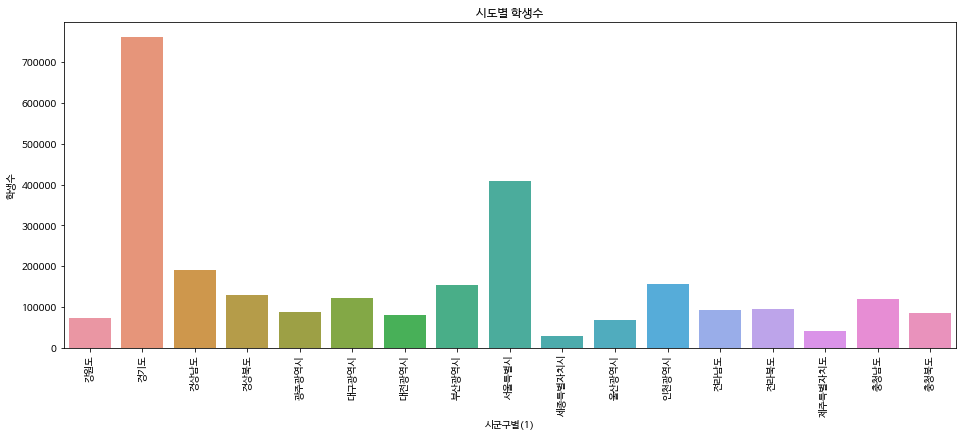

In [20]:
plt.figure(figsize=(16, 6))
sns.barplot(x=df.groupby('시군구별(1)')['학생수'].sum().index, y=df.groupby('시군구별(1)')['학생수'].sum())
plt.title('시도별 학생수')
plt.xticks(rotation=90)
plt.show()

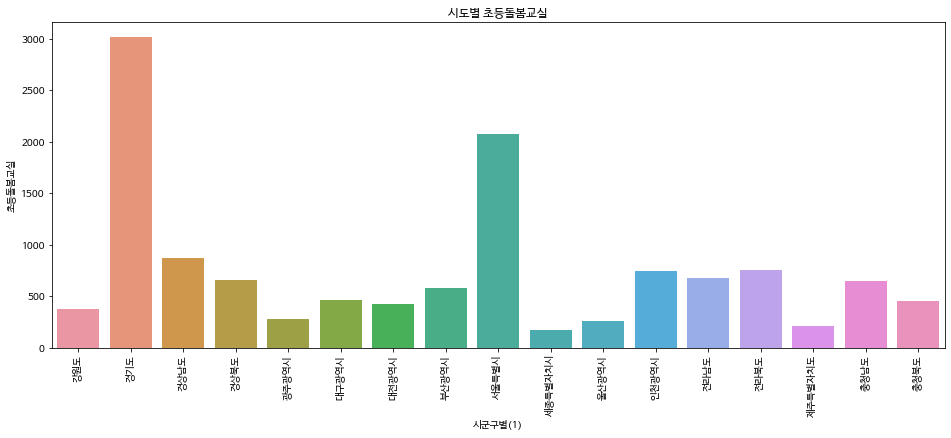

In [21]:
plt.figure(figsize=(16, 6))
sns.barplot(x=df.groupby('시군구별(1)')['초등돌봄교실'].sum().index, y=df.groupby('시군구별(1)')['초등돌봄교실'].sum())
plt.title('시도별 초등돌봄교실')
plt.xticks(rotation=90)
plt.show()

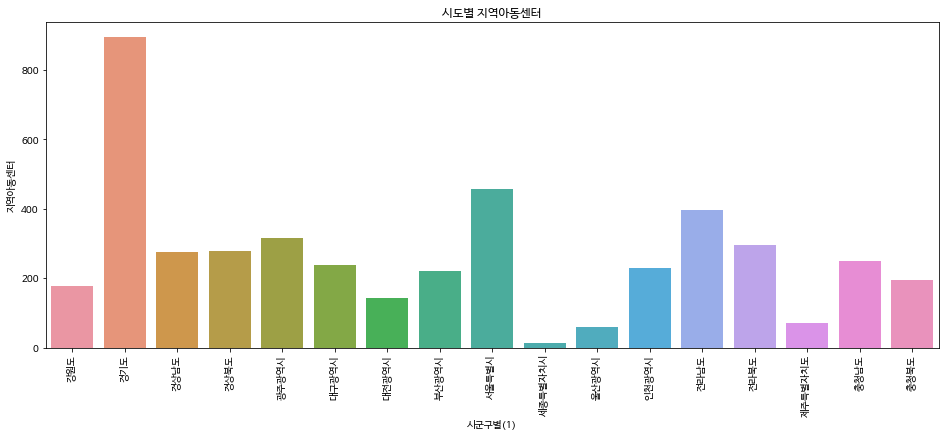

In [22]:
plt.figure(figsize=(16, 6))
sns.barplot(x=df.groupby('시군구별(1)')['지역아동센터'].sum().index, y=df.groupby('시군구별(1)')['지역아동센터'].sum())
plt.title('시도별 지역아동센터')
plt.xticks(rotation=90)
plt.show()

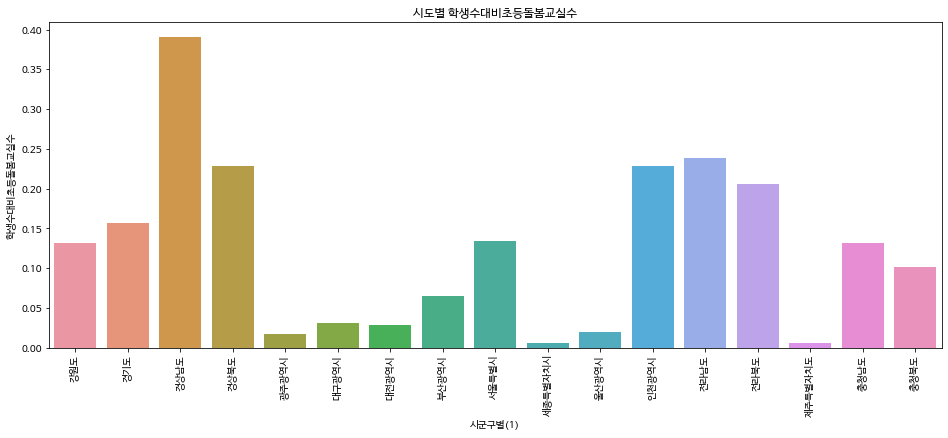

In [23]:
plt.figure(figsize=(16, 6))
sns.barplot(x=df.groupby('시군구별(1)')['학생수대비초등돌봄교실수'].sum().index, y=df.groupby('시군구별(1)')['학생수대비초등돌봄교실수'].sum())
plt.title('시도별 학생수대비초등돌봄교실수')
plt.xticks(rotation=90)
plt.show()

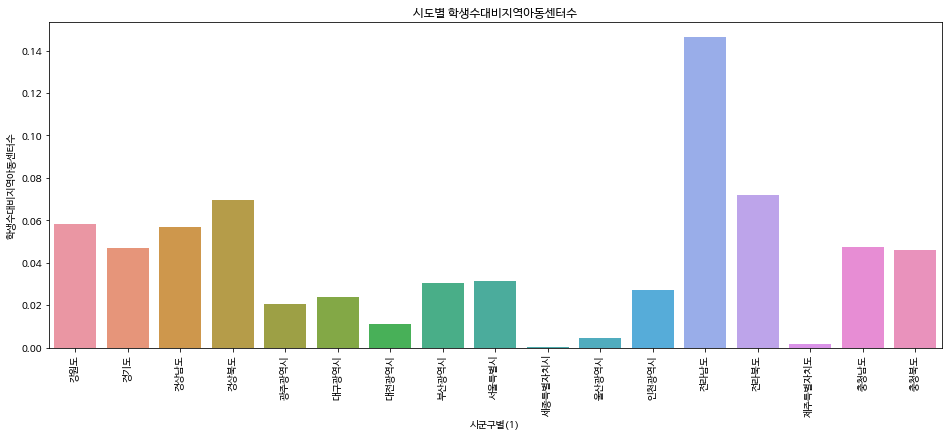

In [24]:
plt.figure(figsize=(16, 6))
sns.barplot(x=df.groupby('시군구별(1)')['학생수대비지역아동센터수'].sum().index, y=df.groupby('시군구별(1)')['학생수대비지역아동센터수'].sum())
plt.title('시도별 학생수대비지역아동센터수')
plt.xticks(rotation=90)
plt.show()

## 돌봄수요 추정 

### 돌봄수요 추정을 위한 파생변수 

전체적인 돌봄수요를 파악하기 위해 학교돌봄시설과 마을돌봄시설을 합한 **돌봄시설합계**라는 파생변수를 생성한다.

In [26]:
(df['초등돌봄교실'] + df['지역아동센터']+ df['다함께돌봄센터']+ df['청소년방과후아카데미']).head()

0    126
1    133
2     66
3    145
4    119
dtype: int64

In [27]:
df['돌봄시설합계']= (df['초등돌봄교실'] + df['지역아동센터']+ df['다함께돌봄센터']+ df['청소년방과후아카데미'])

In [28]:
df['돌봄시설합계'].head()

0    126
1    133
2     66
3    145
4    119
Name: 돌봄시설합계, dtype: int64

In [29]:
df[['시군구별(1)','시군구별(2)','돌봄시설합계']].head()

,시군구별(1),시군구별(2),돌봄시설합계
0,서울특별시,강남구,126
1,서울특별시,강동구,133
2,서울특별시,강북구,66
3,서울특별시,강서구,145
4,서울특별시,관악구,119


### 다항선형회귀 모델링(sklearn)

In [30]:
print(df.dtypes)

시군구별(1)              object
시군구별(2)              object
시도코드                  int64
시군구코드               float64
초등돌봄교실                int64
지역아동센터                int64
다함께돌봄센터               int64
청소년방과후아카데미            int64
비만지수                float64
음주율                 float64
학생수                   int64
교육경비보조금             float64
도서관수                  int64
한부모가구수                int64
학생수대비초등돌봄교실수        float64
학생수대비지역아동센터수        float64
학생수대비다함께돌봄센터수       float64
학생수대비청소년방과후아카데미수    float64
돌봄시설합계                int64
dtype: object


#### Test & Train 데이터 분리하기

In [31]:
from sklearn.model_selection import train_test_split

x = df[['학생수', '비만지수', '음주율', '교육경비보조금','도서관수','한부모가구수']]
y = df[['돌봄시설합계']]

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2)

In [32]:
from sklearn.linear_model import LinearRegression

In [33]:
mlr = LinearRegression()
mlr.fit(x_train, y_train) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

앞서 데이터를 통해 살펴본 현재 강남구의 총 돌봄시설합계는 126곳이다. 

In [34]:
gangnam = [[25905,19.4392,64.4,13851585000,35,818]]
gangnam_predict = mlr.predict(gangnam)
print(gangnam_predict)

[[109.50050189]]


In [35]:
y_predict = mlr.predict(x_test)

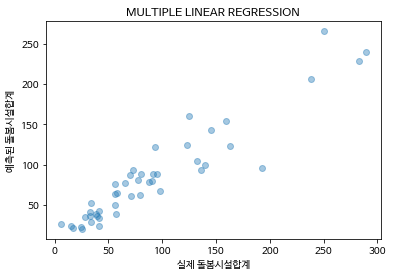

In [36]:
plt.scatter(y_test, y_predict, alpha=0.4)
plt.xlabel("실제 돌봄시설합계")
plt.ylabel("예측된 돌봄시설합계")
plt.title("MULTIPLE LINEAR REGRESSION")
plt.show()

In [37]:
print(mlr.coef_)

[[ 1.81998944e-03  5.93883273e+00 -8.76232570e-01  1.44054635e-09
   9.28406312e-02  4.19284723e-02]]


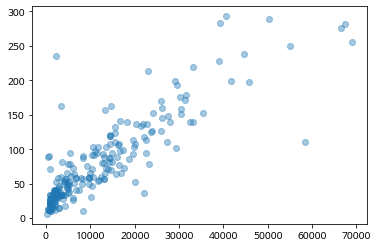

In [38]:
# 학생수와 돌봄시설합계
plt.scatter(df[['학생수']], df[['돌봄시설합계']], alpha=0.4)
plt.show()

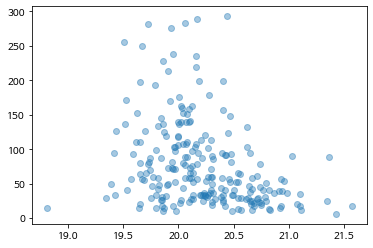

In [39]:
# 비만지수와 돌봄시설합계
plt.scatter(df[['비만지수']], df[['돌봄시설합계']], alpha=0.4)
plt.show()

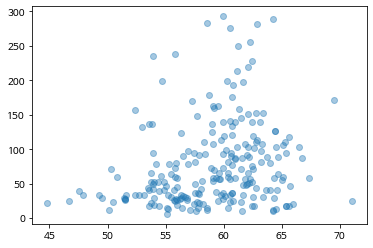

In [40]:
# 음주율과 돌봄시설합계
plt.scatter(df[['음주율']], df[['돌봄시설합계']], alpha=0.4)
plt.show()

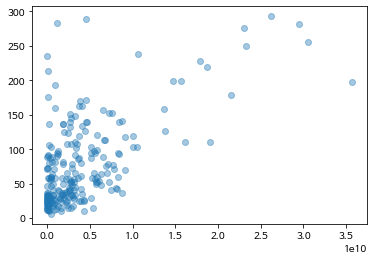

In [41]:
# 교육경비보조금과 돌봄시설합계
plt.scatter(df[['교육경비보조금']], df[['돌봄시설합계']], alpha=0.4)
plt.show()

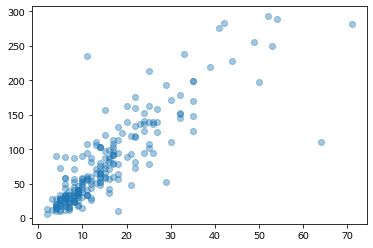

In [42]:
# 도서관과 돌봄시설합계
plt.scatter(df[['도서관수']], df[['돌봄시설합계']], alpha=0.4)
plt.show()

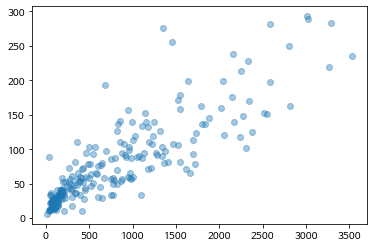

In [43]:
# 한부모가구수와 돌봄시설합계
plt.scatter(df[['한부모가구수']], df[['돌봄시설합계']], alpha=0.4)
plt.show()

In [44]:
print(mlr.score(x_train, y_train))

0.8765181673703732


### 다항선형회귀 모델링(R)

판다스로 만든 파일을 저장 R을 통해 모델링을 해본다.

In [45]:
df.to_csv('df.csv')

In [46]:
%%R
df <- read.csv(file.choose())
summary(df)

Enter file name:df.csv
       X              시군구별.1.  시군구별.2.     시도코드       시군구코드   
 Min.   :  0.00   경기도    :31   동구   :  6   Min.   :11.00   Min.   : 50.0  
 1st Qu.: 56.75   서울특별시:25   중구   :  6   1st Qu.:28.00   1st Qu.:200.0  
 Median :113.50   경상북도  :23   서구   :  5   Median :42.00   Median :390.0  
 Mean   :113.50   전라남도  :22   남구   :  4   Mean   :37.15   Mean   :462.4  
 3rd Qu.:170.25   강원도    :18   북구   :  4   3rd Qu.:46.00   3rd Qu.:750.0  
 Max.   :227.00   경상남도  :18   강서구 :  2   Max.   :50.00   Max.   :940.0  
                  (Other)   :91   (Other):201                   NA's   :1      
  초등돌봄교실     지역아동센터    다함께돌봄센터   청소년방과후아카데미
 Min.   :  5.00   Min.   :  1.00   Min.   : 0.000   Min.   :0.0000      
 1st Qu.: 20.00   1st Qu.:  7.00   1st Qu.: 0.000   1st Qu.:0.0000      
 Median : 41.00   Median : 13.00   Median : 1.000   Median :1.0000      
 Mean   : 55.57   Mean   : 19.81   Mean   : 1.215   Mean   :0.8772      
 3rd Qu.: 76.25   3rd Qu.: 26.00   3rd Qu.: 1.000   3r

모델링 전 단계로 산포도 행렬을 통한 각 변수의 관계와 기초적인 통계 탐색(EDA)을 해본다.

In [ ]:
%%R
install.packages("psych")

In [48]:
%%R
library(psych)

R[write to console]: 
Attaching package: ‘psych’


R[write to console]: The following object is masked from ‘package:car’:

    logit




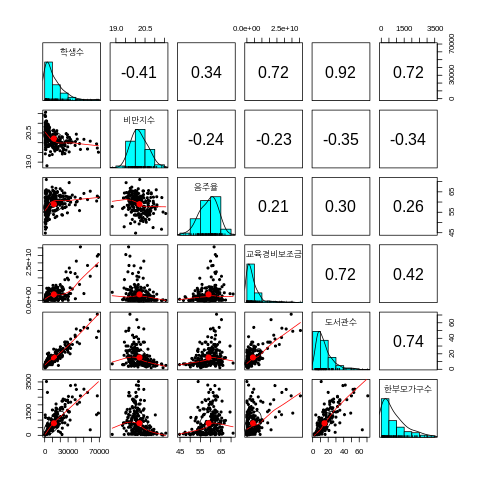

In [49]:
%%R
pairs.panels(df[c('학생수','비만지수','음주율','교육경비보조금','도서관수','한부모가구수')])

#### 모델링

In [50]:
%%R
df_model <- lm(돌봄시설합계 ~학생수+비만지수+음주율+교육경비보조금+도서관수+한부모가구수, data = df)

표준화한 변수로 회귀분석을 통해 각 변수 간 영향력을 비교해본다.

In [51]:
%%R
df_norm <- transform(df, 
                        z.학생수 = scale(학생수),
                        z.비만지수 = scale(비만지수),
                        z.음주율 = scale(음주율),
                        z.교육경비보조금 = scale(교육경비보조금),
                        z.도서관수 = scale(도서관수),
                        z.한부모가구수 = scale(한부모가구수))
head(df_norm)

  X 시군구별.1. 시군구별.2. 시도코드 시군구코드 초등돌봄교실 지역아동센터
1 0  서울특별시      강남구       11        680          117            4
2 1  서울특별시      강동구       11        740          108           23
3 2  서울특별시      강북구       11        305           43           22
4 3  서울특별시      강서구       11        500          121           21
5 4  서울특별시      관악구       11        620           89           30
6 5  서울특별시      광진구       11        215           69           16
  다함께돌봄센터 청소년방과후아카데미 비만지수 음주율 학생수 교육경비보조금
1              4                    1 19.43920   64.4  25905    13851585000
2              1                    1 19.81522   60.7  21353     4103795000
3              0                    1 20.10714   62.1   9913     3276998000
4              2                    1 19.84444   61.5  26078     2821710000
5              0                    0 19.88764   60.0  14410     3764509000
6              2                    0 19.83933   61.6  14257     3743149000
  도서관수 한부모가구수 학생수대비초등돌봄교실수 학생수대비지역아동센터수
1       35          8

In [52]:
%%R
df_norm_lm <- lm(돌봄시설합계 ~z.학생수+z.비만지수+z.음주율+z.교육경비보조금+z.도서관수+z.한부모가구수, data = df_norm)   
summary(df_norm_lm)


Call:
lm(formula = 돌봄시설합계 ~ z.학생수 + z.비만지수 + 
    z.음주율 + z.교육경비보조금 + z.도서관수 + 
    z.한부모가구수, data = df_norm)

Residuals:
    Min      1Q  Median      3Q     Max 
-71.997 -10.228  -1.138   8.986  83.947 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)        77.465      1.437  53.919  < 2e-16 ***
z.학생수           25.898      4.077   6.352  1.2e-09 ***
z.비만지수          3.484      1.607   2.168  0.03122 *  
z.음주율           -4.125      1.545  -2.669  0.00816 ** 
z.교육경비보조금    3.261      2.237   1.458  0.14634    
z.도서관수          6.743      4.085   1.651  0.10024    
z.한부모가구수     30.626      2.282  13.423  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 21.69 on 221 degrees of freedom
Multiple R-squared:  0.8807,	Adjusted R-squared:  0.8775 
F-statistic:   272 on 6 and 221 DF,  p-value: < 2.2e-16



각 변수간 **상대적 중요도**를 확인해본다.

In [ ]:
%%R
install.packages("ggplot2")

In [54]:
%%R
library(ggplot2)

R[write to console]: 
Attaching package: ‘ggplot2’


R[write to console]: The following objects are masked from ‘package:psych’:

    %+%, alpha




In [55]:
%%R
relweights <- function(fit,...){
  
  R <- cor(fit$model)
  nvar <- ncol(R)
  rxx <- R[2:nvar, 2:nvar]
  rxy <- R[2:nvar, 1]
  svd <- eigen(rxx)
  evec <- svd$vectors
  ev <- svd$values
  delta <- diag(sqrt(ev))
  lambda <- evec %*% delta %*% t(evec)
  lambdasq <- lambda ^ 2
  beta <- solve(lambda) %*% rxy
  rsquare <- colSums(beta ^ 2)
  rawwgt <- lambdasq %*% beta ^ 2
  import <- (rawwgt / rsquare) * 100
  import <- as.data.frame(import)
  row.names(import) <- names(fit$model[2:nvar])
  names(import) <- "Weights"
  import <- import[order(import),1, drop=FALSE]
  dotchart(import$Weights, labels=row.names(import),
           xlab="% of R-Square", pch=19,
           main="Relative Importance of Predictor Variables",
           sub=paste("Total R-Square=", round(rsquare, digits=3)),
           ...)
  return(import)
}

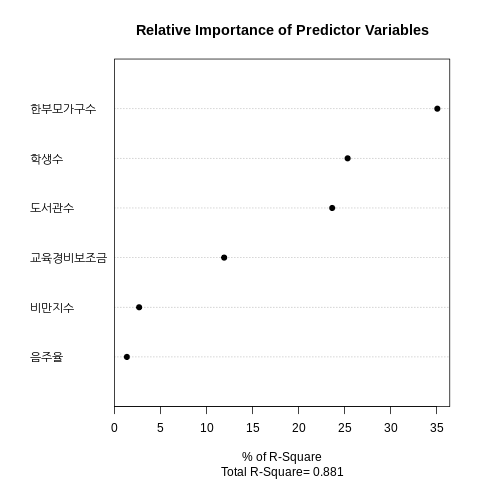

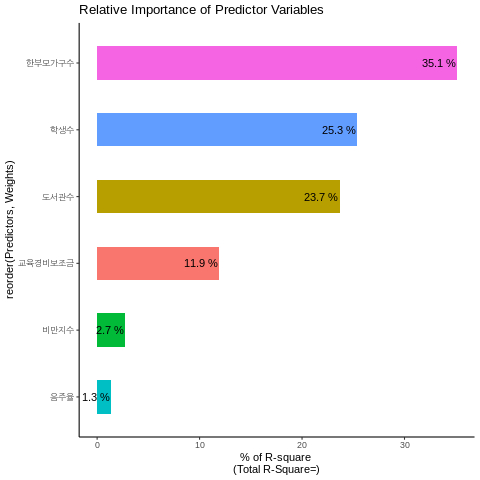

In [56]:
%%R
plotRelWeights=function(fit){
  data<-relweights(fit)
  data$Predictors<-rownames(data)
  p <-ggplot(data=data,aes(x=reorder(Predictors,Weights),y=Weights,fill=Predictors))+ 
       geom_bar(stat="identity",width=0.5)+
       ggtitle("Relative Importance of Predictor Variables")+
       ylab(paste0("% of R-square \n(Total R-Square=",attr(data,"R-square"),")"))+
       geom_text(aes(y=Weights-0.1,label=paste(round(Weights,1),"%")),hjust=1)+
       guides(fill=FALSE)+
       coord_flip()+
       theme_classic()
  p
}

plotRelWeights(df_model)

#### 모델링 성능평가

In [57]:
%%R
summary(df_model)


Call:
lm(formula = 돌봄시설합계 ~ 학생수 + 비만지수 + 
    음주율 + 교육경비보조금 + 도서관수 + 한부모가구수, 
    data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-71.997 -10.228  -1.138   8.986  83.947 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -9.622e+01  8.051e+01  -1.195  0.23333    
학생수          1.973e-03  3.107e-04   6.352  1.2e-09 ***
비만지수        8.068e+00  3.721e+00   2.168  0.03122 *  
음주율         -9.383e-01  3.515e-01  -2.669  0.00816 ** 
교육경비보조금  5.910e-10  4.054e-10   1.458  0.14634    
도서관수        5.951e-01  3.605e-01   1.651  0.10024    
한부모가구수    3.927e-02  2.926e-03  13.423  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 21.69 on 221 degrees of freedom
Multiple R-squared:  0.8807,	Adjusted R-squared:  0.8775 
F-statistic:   272 on 6 and 221 DF,  p-value: < 2.2e-16



#### 모델링 개선

첫번째로, VIF분석을 우선 진행하여 각 독립변수들간의 다중공선성을 확인 및 제거해 모델을 개선해본다.

In [58]:
%%R
vif(df_model)

        학생수       비만지수         음주율 교육경비보조금       도서관수 
      8.018192       1.245816       1.151672       2.413730       8.048535 
  한부모가구수 
      2.511077 


In [59]:
%%R
df_model2 <- lm(돌봄시설합계 ~학생수+비만지수+음주율+교육경비보조금+한부모가구수, data = df)

In [60]:
%%R
summary(df_model2)


Call:
lm(formula = 돌봄시설합계 ~ 학생수 + 비만지수 + 
    음주율 + 교육경비보조금 + 한부모가구수, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-74.728 -10.414  -0.865   8.841  86.887 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -1.017e+02  8.076e+01  -1.259  0.20933    
학생수          2.328e-03  2.255e-04  10.320  < 2e-16 ***
비만지수        8.541e+00  3.725e+00   2.293  0.02277 *  
음주율         -9.603e-01  3.526e-01  -2.723  0.00698 ** 
교육경비보조금  7.809e-10  3.903e-10   2.001  0.04663 *  
한부모가구수    4.093e-02  2.759e-03  14.838  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 21.78 on 222 degrees of freedom
Multiple R-squared:  0.8792,	Adjusted R-squared:  0.8765 
F-statistic: 323.3 on 5 and 222 DF,  p-value: < 2.2e-16



두번째로, 2가지 변수선택 방법을 통해 모델링을 개선하도록 한다.

**1. Stepwise regression(단계적 변수선택)**

성능개선을 위해 STEP 함수를 이용하여 무의미한 독립변수 제거하여 모델을 최적화 한다. STEP 함수는 'Stepwise Algorithm의 AIC'를 통해 모델을 적합화 할 수 있는데, 간단히 말하면 여러 변수들이 들어간 회귀식의 AIC를 확인해보며 가장 적절한 모델을 찾아주는 함수이다.즉, **최적화 된 회귀모델은 'AIC가 가장 작은 값'**을 말한다.

**AIC**란 **A**kaike **i**nformation **c**riterion의 줄임말로 동일한 데이터셋을 사용해 만들어진 모델 중 상대적으로 Quality가 좋은 모델을 선정해주는 함수이며 값이 작을수록 좋다.

In [62]:
%%R
df.null <- lm(돌봄시설합계 ~ 1,   data = df)      
df.full <- lm(돌봄시설합계 ~ 학생수+비만지수+음주율+교육경비보조금+도서관수+한부모가구수 ,  data = df)

In [63]:
%%R
step(df.full, data = df, direction = "backward")

Start:  AIC=1410.01
돌봄시설합계 ~ 학생수 + 비만지수 + 음주율 + 교육경비보조금 + 
    도서관수 + 한부모가구수

                 Df Sum of Sq    RSS    AIC
<none>                        104005 1410.0
- 교육경비보조금  1      1000 105005 1410.2
- 도서관수        1      1282 105287 1410.8
- 비만지수        1      2212 106217 1412.8
- 음주율          1      3353 107359 1415.2
- 학생수          1     18988 122993 1446.2
- 한부모가구수    1     84792 188798 1544.0

Call:
lm(formula = 돌봄시설합계 ~ 학생수 + 비만지수 + 
    음주율 + 교육경비보조금 + 도서관수 + 한부모가구수, 
    data = df)

Coefficients:
   (Intercept)          학생수        비만지수          음주율  교육경비보조금  
    -9.622e+01       1.973e-03       8.068e+00      -9.383e-01       5.910e-10  
      도서관수    한부모가구수  
     5.951e-01       3.927e-02  



In [64]:
%%R
step(df.null, scope = list(upper = df.full) ,  data = df, direction = "both")

Start:  AIC=1882.79
돌봄시설합계 ~ 1

                 Df Sum of Sq    RSS    AIC
+ 학생수          1    656873 215039 1565.6
+ 한부모가구수    1    648294 223619 1574.5
+ 도서관수        1    643666 228247 1579.2
+ 교육경비보조금  1    326315 545598 1777.9
+ 비만지수        1     90086 781826 1859.9
+ 음주율          1     48427 823486 1871.8
<none>                        871913 1882.8

Step:  AIC=1565.62
돌봄시설합계 ~ 학생수

                 Df Sum of Sq    RSS    AIC
+ 한부모가구수    1    100317 114723 1424.4
+ 도서관수        1     19882 195158 1545.5
+ 음주율          1      3604 211436 1563.8
<none>                        215039 1565.6
+ 비만지수        1      1486 213554 1566.0
+ 교육경비보조금  1       393 214646 1567.2
- 학생수          1    656873 871913 1882.8

Step:  AIC=1424.37
돌봄시설합계 ~ 학생수 + 한부모가구수

                 Df Sum of Sq    RSS    AIC
+ 음주율          1      4626 110097 1417.0
+ 비만지수        1      3774 110949 1418.8
+ 도서관수        1      3117 111606 1420.1
+ 교육경비보조금  1      2686 112037 1421.0
<none>                        114723 14

STEP 함수를 이용하여 예측된 변수는 기존 변수의 개수와 동일하다.

**2. All subset regression(부분집합회귀분석)**

Stepwise와 달리 변수의 모든 조합으로 구성된 회귀모델을 전부 만들어 비교해본다.

In [66]:
%%R
df_allsubset<- regsubsets(돌봄시설합계 ~학생수+비만지수+음주율+교육경비보조금+도서관수+한부모가구수, data = df)
summary(df_allsubset)

Subset selection object
Call: regsubsets.formula(돌봄시설합계 ~ 학생수 + 비만지수 + 
    음주율 + 교육경비보조금 + 도서관수 + 한부모가구수, 
    data = df)
6 Variables  (and intercept)
               Forced in Forced out
학생수             FALSE      FALSE
비만지수           FALSE      FALSE
음주율             FALSE      FALSE
교육경비보조금     FALSE      FALSE
도서관수           FALSE      FALSE
한부모가구수       FALSE      FALSE
1 subsets of each size up to 6
Selection Algorithm: exhaustive
         학생수 비만지수 음주율 교육경비보조금 도서관수 한부모가구수
1  ( 1 ) "*"    " "      " "    " "            " "      " "         
2  ( 1 ) "*"    " "      " "    " "            " "      "*"         
3  ( 1 ) "*"    " "      "*"    " "            " "      "*"         
4  ( 1 ) "*"    "*"      "*"    " "            " "      "*"         
5  ( 1 ) "*"    "*"      "*"    " "            "*"      "*"         
6  ( 1 ) "*"    "*"      "*"    "*"            "*"      "*"         


In [67]:
%%R
summary(df_allsubset)$bic

[1] -308.3111 -446.1345 -450.0891 -450.7696 -450.0268 -446.7793


In [68]:
%%R
df_model3 <- lm(돌봄시설합계 ~학생수+비만지수+음주율+한부모가구수, data = df)

In [69]:
%%R
summary(df_model3)


Call:
lm(formula = 돌봄시설합계 ~ 학생수 + 비만지수 + 
    음주율 + 한부모가구수, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-78.590 -11.817  -0.796   9.117  79.355 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -1.124e+02  8.112e+01  -1.386  0.16724    
학생수        2.628e-03  1.693e-04  15.523  < 2e-16 ***
비만지수      9.193e+00  3.735e+00   2.461  0.01461 *  
음주율       -9.922e-01  3.546e-01  -2.798  0.00559 ** 
한부모가구수  3.974e-02  2.712e-03  14.656  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 21.92 on 223 degrees of freedom
Multiple R-squared:  0.8771,	Adjusted R-squared:  0.8749 
F-statistic: 397.8 on 4 and 223 DF,  p-value: < 2.2e-16



### 다중선형회귀 모델 예측


만든 모델3개를 통해 서울특별시 강남구에 대한 해당 모델적용해 예측해본다. 현재 강남구의 돌봄시설합계는 총 126곳이다.

In [70]:
#예측변수 6개의 df_model
-9.622e+01+(1.973e-03*25905)+(8.068e+00*19.439200)+(-9.383e-01*64.4)+(5.910e-10*1.385158e+10)+(5.951e-01*35)+(3.927e-02*818)

112.43715438000001

In [71]:
#예측변수 5개의 df_model2
-1.017e+02+(2.328e-03*25905)+(8.541e+00*19.439200)+(-9.603e-01*64.4) +(7.809e-10*1.385158e+10)+(4.093e-02*818)

107.09116602200001

In [72]:
#예측변수 4개의 df_model3
-1.124e+02+(2.628e-03*25905)+(9.193e+00*19.439200)+(-9.922e-01*64.4)+(3.974e-02*818)

102.99254559999997

In [73]:
df['돌봄시설합계']= (df['초등돌봄교실'] + df['지역아동센터']+ df['다함께돌봄센터']+ df['청소년방과후아카데미'])

df['예측값'] = (-9.622e+01 + (1.973e-03*df['학생수'])+(8.068e+00*df['비만지수'])+(-9.383e-01*df['음주율'])+(5.910e-10*df['교육경비보조금'])+(5.951e-01*df['도서관수'])+(3.927e-02*df['한부모가구수']))
df['차이값'] = (df['예측값'] - df['돌봄시설합계'])

### 핵심데이터 column 추출 

In [74]:
df_main = df[['시군구별(1)','시군구별(2)','돌봄시설합계','예측값','차이값']]

### 돌봄시설 우선공급 지역 Top20

In [75]:
df_main.sort_values(by='차이값', ascending=False).head(20)

,시군구별(1),시군구별(2),돌봄시설합계,예측값,차이값
51,인천광역시,미추홀구,102,173.970132,71.970132
214,경상남도,창원시,111,181.541345,70.541345
47,대구광역시,수성구,79,138.800390,59.800390
95,경기도,성남시,198,247.163089,49.163089
212,경상남도,김해시,153,198.354644,45.354644
58,인천광역시,중구,10,53.544699,43.544699
41,대구광역시,남구,34,76.443746,42.443746
54,인천광역시,부평구,125,165.990727,40.990727
55,인천광역시,서구,140,178.657168,38.657168
42,대구광역시,달서구,151,188.350926,37.350926


In [79]:
df[df['시군구별(2)'] == '미추홀구']

,시군구별(1),시군구별(2),시도코드,시군구코드,초등돌봄교실,지역아동센터,다함께돌봄센터,청소년방과후아카데미,비만지수,음주율,학생수,교육경비보조금,도서관수,한부모가구수,학생수대비초등돌봄교실수,학생수대비지역아동센터수,학생수대비다함께돌봄센터수,학생수대비청소년방과후아카데미수,돌봄시설합계,예측값,차이값
51,인천광역시,미추홀구,28,177.0,87,15,0,0,20.269388,62.6,29286,3.421005e+09,25,2310,0.002971,0.000512,0.0,0.0,102,173.970132,71.970132


[인천 '라면 형제' 비극](https://news.joins.com/article/23874431) (출처 : 중앙일보)

실제 돌봄시설이 가장 부족한 지역인 **인천 미추홀구**는 최근 라면화재로 전국민을 가슴아프게한, 온몸에 화상을 입고 여전히 의식이 불분명한 형제들이 사는 곳이다. 현재 인천의 경우 이 사건을 계기로 대대적인 돌봄서비스에 대한 전수조사가 이루어 지고 있다. 


### 돌봄시설 공급과잉 지역 Top20

In [80]:
df_main.sort_values(by='차이값', ascending=True).head(20)

,시군구별(1),시군구별(2),돌봄시설합계,예측값,차이값
74,세종특별자치시,세종시,193,109.032870,-83.967130
221,경상남도,창녕군,235,165.306376,-69.693624
57,인천광역시,옹진군,88,24.033474,-63.966526
83,경기도,양주시,157,95.580665,-61.419335
62,광주광역시,북구,213,156.054305,-56.945695
174,전라남도,순천시,141,95.230050,-45.769950
105,경기도,화성시,276,230.311953,-45.688047
161,전라북도,전주시,283,243.213735,-39.786265
19,서울특별시,영등포구,103,64.669111,-38.330889
153,전라북도,남원시,81,43.006048,-37.993952


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


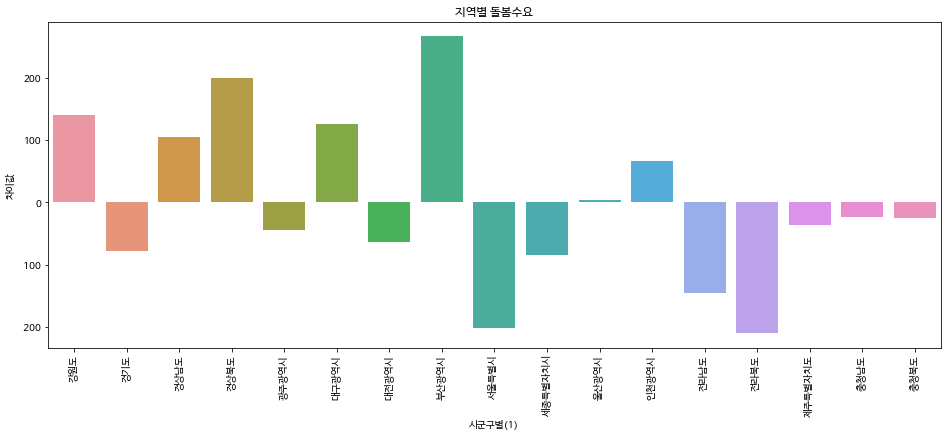

In [81]:
plt.figure(figsize=(16, 6))
sns.barplot(x=df.groupby('시군구별(1)')['차이값'].sum().index, y=df.groupby('시군구별(1)')['차이값'].sum())
plt.title('지역별 돌봄수요')
plt.xticks(rotation=90)
plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


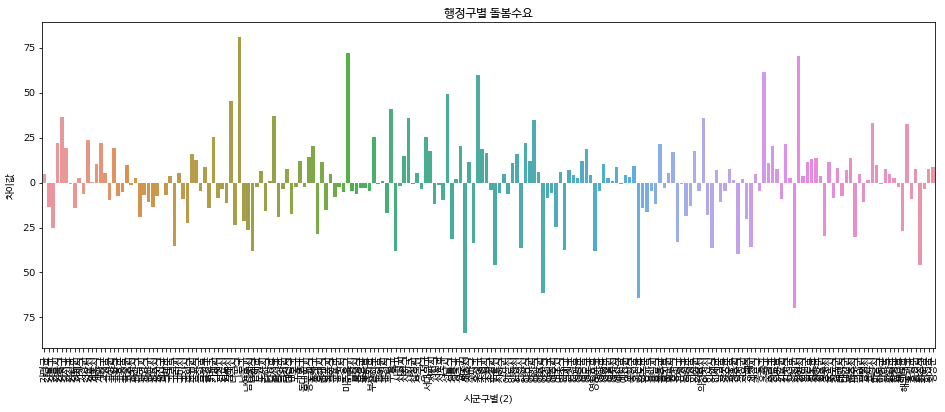

In [82]:
plt.figure(figsize=(16, 6))
sns.barplot(x=df.groupby('시군구별(2)')['차이값'].sum().index, y=df.groupby('시군구별(2)')['차이값'].sum())
plt.title('행정구별 돌봄수요')
plt.xticks(rotation=90)
plt.show()

In [ ]:
df.to_excel('df.xlsx')

In [ ]:
df_main.to_excel('df_main.xlsx')

## 최종 : 웹서비스 구현(프로토타입)

현재 학교돌봄과 마을돌봄에 대한 공시정보를 **한꺼번에 확인이 가능한 서비스**가 존재하지 않는다. **지자체별 마을 돌봄과 학교돌봄에 대한 통합적인 현황을 보여주고 모델링한 결과를 통해 지자체별 필요한 돌봄수요까지 시각화해 나타낼수 있는 서비스**를 구현한다. 

최종적으로 구현할 웹서비스에 앞서 구글 데이터 스튜디오(https://datastudio.google.com/) 를 활용하여 구상한 서비스에 대한 프로토타입을 제작해보고 아이디어에 대한 실현가능성 및 개선사항에 대해 검토해본다.

[서비스명 : 온종일돌봄24](https://datastudio.google.com/reporting/673c2e63-a815-4720-9ec6-5ec301d04a5a)